Lectura de la base

In [1]:
!mv kaggle.json /root/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
!mkdir ~/.kaggle


In [3]:
import json
from google.colab import drive

!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json


Mounted at /content/drive


In [4]:
!kaggle competitions download -c analisis-predictivo-2023q1

  0% 0.00/3.83M [00:00<?, ?B/s]
100% 3.83M/3.83M [00:00<00:00, 231MB/s]


In [5]:
import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
train = pd.read_csv('/content/base_train.csv')
test = pd.read_csv('/content/base_val.csv')

### Vistazo general

In [ ]:
print(train.columns)

In [ ]:
train.head()

In [ ]:
data_types = train.dtypes.value_counts()
print(data_types)

object     29
int64      22
float64    17
dtype: int64


### Tratamiento de nulos y outliers

In [ ]:
null_counts = train.isnull().sum()
variables_con_nulos = null_counts[null_counts > 0]
null_table = pd.DataFrame(variables_con_nulos, columns=['Cantidad de Valores Nulos'])
print(null_table)

In [36]:
train = train.drop(['neighbourhood_group_cleansed', 'calendar_updated'], axis=1)
test = test.drop(['neighbourhood_group_cleansed', 'calendar_updated'], axis=1)

In [ ]:
numeric_columns = train.select_dtypes(include=['float64', 'int64'])
fig, axes = plt.subplots(len(numeric_columns.columns), 1, figsize=(8, len(numeric_columns.columns) * 4))
fig.tight_layout(pad=3.0)
for i, column in enumerate(numeric_columns.columns):
    ax = axes[i]
    sns.boxplot(data=train, y=column, ax=ax)
    ax.set_title(column)
plt.show()

### Correlacion entre variables y la target

In [ ]:
import matplotlib.pyplot as plt

# Calcular los coeficientes de correlación entre 'review_scores_rating' y el resto de variables
correlation_scores = train.corr()['review_scores_rating'].drop('review_scores_rating')

# Filtrar las variables con correlación mayor a 0.15
high_corr_vars = correlation_scores[abs(correlation_scores) > 0.15]

# Graficar la correlación en forma de barras
plt.figure(figsize=(10, 6))
high_corr_vars.plot(kind='bar')
plt.xlabel('Variables')
plt.ylabel('Coeficiente de correlación')
plt.title('Correlación entre Review Scores Rating y otras variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = train.corr()
correlation_threshold = 0.15
high_corr_vars = corr_matrix[abs(corr_matrix['review_scores_rating']) > correlation_threshold]['review_scores_rating'].index
corr_submatrix = train[high_corr_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_submatrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Review scores rating y otras variables')
plt.show()

### Transformación de la base

In [37]:
train['host_since_year'] = pd.to_datetime(train['host_since']).dt.year
test['host_since_year'] = pd.to_datetime(test['host_since']).dt.year


In [ ]:
response_time_mapping = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
    }
train['host_response_time_b'] = train['host_response_time'].replace(response_time_mapping)
test['host_response_time_b'] = test['host_response_time'].replace(response_time_mapping)

In [9]:
t_f_mapping = {
    't': 1, 'f': 0
    }
train['host_is_superhost_b'] = train['host_is_superhost'].replace(t_f_mapping)
train['host_has_profile_pic_b'] = train['host_has_profile_pic'].replace(t_f_mapping)
train['host_identity_verified_b'] = train['host_identity_verified'].replace(t_f_mapping)
train['has_availability_b'] = train['has_availability'].replace(t_f_mapping)
train['instant_bookable_b'] = train['instant_bookable'].replace(t_f_mapping)
test['host_is_superhost_b'] = test['host_is_superhost'].replace(t_f_mapping)
test['host_has_profile_pic_b'] = test['host_has_profile_pic'].replace(t_f_mapping)
test['host_identity_verified_b'] = test['host_identity_verified'].replace(t_f_mapping)
test['has_availability_b'] = test['has_availability'].replace(t_f_mapping)
test['instant_bookable_b'] = test['instant_bookable'].replace(t_f_mapping)

In [41]:
import re
train['bathrooms_text'] = train['bathrooms_text'].fillna('')
test['bathrooms_text'] = test['bathrooms_text'].fillna('')
def extract_bathrooms(text):
    match = re.search(r'(\d+(\.\d+)?)', text)
    if match:
        return float(match.group())
    else:
        return None
train['bathrooms'] = train['bathrooms_text'].apply(extract_bathrooms)
test['bathrooms'] = test['bathrooms_text'].apply(extract_bathrooms)


In [42]:
def filter_bathrooms(text):
    patterns = ['shared baths?', 'shared bath', 'baths?', 'bath', 'private bath']
    matches = re.findall('|'.join(patterns), text)
    return ' '.join(matches)
train['bathrooms_text'] = train['bathrooms_text'].apply(filter_bathrooms)
test['bathrooms_text'] = test['bathrooms_text'].apply(filter_bathrooms)

In [ ]:
train['room_type_num'] = train['room_type'].map({'Private room': 1, 'Entire home/apt': 2, 'Hotel room': 3, 'Shared room': 4})
train['bathrooms_text_num'] = train['bathrooms_text'].map({'shared baths': 1, 'shared bath': 1, 'baths': 2, 'bath': 2, 'private bath': 3})

test['room_type_num'] = test['room_type'].map({'Private room': 1, 'Entire home/apt': 2, 'Hotel room': 3, 'Shared room': 4})
test['bathrooms_text_num'] = test['bathrooms_text'].map({'shared baths': 1, 'shared bath': 1, 'baths': 2, 'bath': 2, 'private bath': 3})

In [ ]:
train['source_b'] = train['source'].map({'city scrape': 1, 'previous scrape': 0})
train['calendar_last_scraped_b'] = train['calendar_last_scraped'].map({'2022-12-05': 1, '2022-12-17': 0})

test['source_b'] = test['source'].map({'city scrape': 1, 'previous scrape': 0})
test['calendar_last_scraped_b'] = test['calendar_last_scraped'].map({'2022-12-05': 1, '2022-12-17': 0})

In [44]:
train['cant_amenities'] = train['amenities'].apply(lambda x: len(x.split(',')))
test['cant_amenities'] = test['amenities'].apply(lambda x: len(x.split(',')))

In [45]:
from sklearn.preprocessing import LabelEncoder
neighbourhood_encoder = LabelEncoder()
train['neighbourhood_cleansed_encoded'] = neighbourhood_encoder.fit_transform(train['neighbourhood_cleansed'])
test['neighbourhood_cleansed_encoded'] = neighbourhood_encoder.transform(test['neighbourhood_cleansed'])

In [46]:
from datetime import datetime
import math
train['antiguedad'] = (pd.to_datetime(train['last_review']) - pd.to_datetime(train['first_review'])).dt.days
train['antiguedad'] = train['antiguedad'].apply(lambda x: math.trunc(x / 365))
test['antiguedad'] = (pd.to_datetime(test['last_review']) - pd.to_datetime(test['first_review'])).dt.days
test['antiguedad'] = test['antiguedad'].apply(lambda x: math.trunc(x / 365))

In [47]:
train['price'] = train['price'].str.replace('$', '')
train['price'] = train['price'].str.replace(',', '')
train['price'] = pd.to_numeric(train['price'])
test['price'] = test['price'].str.replace('$', '')
test['price'] = test['price'].str.replace(',', '')
test['price'] = pd.to_numeric(test['price'])

<ipython-input-47-89fb38b8eadb>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train['price'] = train['price'].str.replace('$', '')
<ipython-input-47-89fb38b8eadb>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['price'] = test['price'].str.replace('$', '')


In [48]:
train['host_acceptance_rate'] = train['host_acceptance_rate'].str.rstrip('%').astype(float) / 100
train['host_response_rate'] = train['host_response_rate'].str.rstrip('%').astype(float) / 100
test['host_response_rate'] = test['host_response_rate'].str.rstrip('%').astype(float) / 100
test['host_acceptance_rate'] = test['host_acceptance_rate'].str.rstrip('%').astype(float) / 100

In [49]:
train['review_scores_total'] = (train['review_scores_accuracy'] + train['review_scores_cleanliness'] +
                                 train['review_scores_checkin'] + train['review_scores_communication'] +
                                 train['review_scores_location'] + train['review_scores_value'])
test['review_scores_total'] = (test['review_scores_accuracy'] + test['review_scores_cleanliness'] +
                                 test['review_scores_checkin'] + test['review_scores_communication'] +
                                 test['review_scores_location'] + test['review_scores_value'])

In [50]:
train['host_listings_ratio'] = train['host_listings_count'] / train.groupby('neighbourhood_cleansed')['host_listings_count'].transform('sum')
test['host_listings_ratio'] = test['host_listings_count'] / test.groupby('neighbourhood_cleansed')['host_listings_count'].transform('sum')

In [51]:
train['host_response_ratio'] = train['host_response_rate'] / train['host_listings_count']
train['host_acceptance_ratio'] = train['host_acceptance_rate'] / train['host_listings_count']
test['host_response_ratio'] = test['host_response_rate'] / test['host_listings_count']
test['host_acceptance_ratio'] = test['host_acceptance_rate'] / test['host_listings_count']

In [52]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

train['log_price'] = np.log(train['price'])
test['log_price'] = np.log(test['price'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [53]:
train['minimum_maximum_nights_ratio'] = train['minimum_nights'] / train['maximum_nights']
test['minimum_maximum_nights_ratio'] = test['minimum_nights'] / test['maximum_nights']

In [54]:
train['minimum_maximum_nights_diff'] = train['maximum_nights'] - train['minimum_nights']
test['minimum_maximum_nights_diff'] = test['maximum_nights'] - test['minimum_nights']

In [55]:
from textblob import TextBlob
train['description_sentiment'] = train['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
test['description_sentiment'] = test['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

In [ ]:
print(train.columns)

### Tratar con los missings

In [28]:
from sklearn.impute import KNNImputer
train=train.select_dtypes().columns.to_list()
faltantes = train.isnull().sum()
columnas_faltantes = faltantes[faltantes > 0].index
imputador = KNNImputer(n_neighbors=5)
train[columnas_faltantes] = imputador.fit_transform(train[columnas_faltantes])

In [58]:
test=test.select_dtypes().columns.to_list()
faltantes = test.isnull().sum()
columnas_faltantes = faltantes[faltantes > 0].index
imputador = KNNImputer(n_neighbors=5)
test[columnas_faltantes] = imputador.fit_transform(test[columnas_faltantes])

# Analisis exploratorio

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='room_type', order=train['room_type'].value_counts().index)
plt.xlabel('Room Type')
plt.ylabel('Conteo')
plt.title('Distribución de Room Type')
plt.xticks(rotation=45)
plt.show()

In [ ]:
cantidad_alojamientos = train['neighbourhood_cleansed'].value_counts()
plt.figure(figsize=(12, 6))
cantidad_alojamientos.plot(kind='bar')
plt.xlabel('Barrio')
plt.ylabel('Cantidad de Alojamientos')
plt.title('Cantidad de Alojamientos por Barrio')
plt.xticks(rotation=90)
plt.show()

In [ ]:
import folium
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_app")
alojamientos_por_barrio = train['neighbourhood_cleansed'].value_counts().to_dict()
barrios = train['neighbourhood_cleansed'].unique()
barrios_coords = {}
for barrio in barrios:
    location = geolocator.geocode(barrio + ", Amsterdam")
    if location:
        barrios_coords[barrio] = (location.latitude, location.longitude)
mapa_amsterdam = folium.Map(location=[52.370216, 4.895168], zoom_start=12)
for barrio, coords in barrios_coords.items():
    alojamientos = alojamientos_por_barrio.get(barrio, 0)
    popup_text = f"{barrio}<br>Alojamientos: {alojamientos}"
    folium.Marker(location=coords, popup=popup_text).add_to(mapa_amsterdam)
mapa_amsterdam

### Analisis de la variable a predecir: review_scores_rating

In [12]:
print(train['review_scores_rating'].describe())

count    4928.000000
mean        4.812330
std         0.264727
min         0.000000
25%         4.750000
50%         4.880000
75%         4.990000
max         5.000000
Name: review_scores_rating, dtype: float64


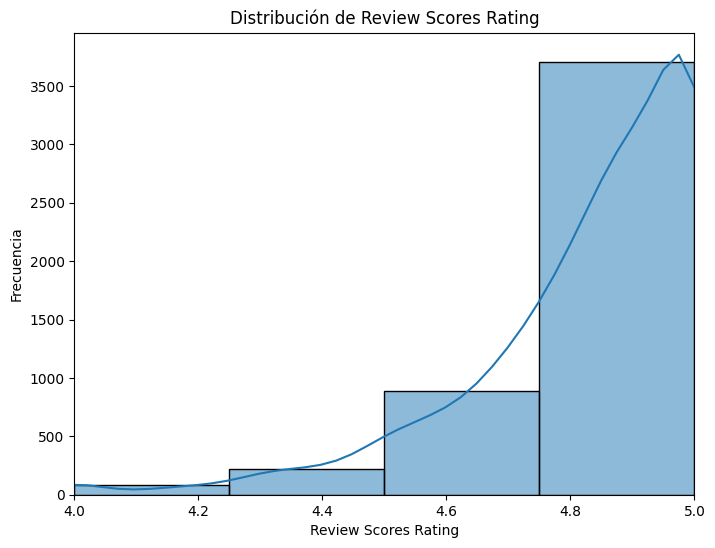

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(train['review_scores_rating'], bins=20, kde=True)
plt.xlabel('Review Scores Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Review Scores Rating')
plt.xlim(4, train['review_scores_rating'].max())
plt.show()

# Analisis predictivo

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score

In [60]:
columns_num = train.select_dtypes().columns.to_list()
columns_num.remove('review_scores_rating')

X = train[columns_num] 
y = train['review_scores_rating'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
Z = test


In [ ]:
print(X.columns)

# Random Forest

In [61]:
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)
random_forest_preds = random_forest_reg.predict(X_test)
random_forest_accuracy = random_forest_reg.score(X_test, y_test)
print("Precisión de Bosque Aleatorio:", random_forest_accuracy)

Precisión de Bosque Aleatorio: 0.8128835423672653


In [ ]:
scores = cross_val_score(random_forest_reg, X, y, cv=20, scoring='r2')
print("Puntajes de validación cruzada:", scores)
print("Puntaje promedio de validación cruzada:", scores.mean())

In [62]:
param_grid  = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=15)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.set_params(max_depth=10)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
mean_cv_score = cv_scores.mean()
print("Puntajes de validación cruzada:", cv_scores)
print("Puntuación promedio de la validación cruzada:", mean_cv_score)
print(best_params)

Puntajes de validación cruzada: [0.76238567 0.74664083 0.75283926 0.7820809  0.52877466]
Puntuación promedio de la validación cruzada: 0.714544264652457
{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
parameters = {
    'n_estimators': [300],
    'max_depth': [10],  # Corregir aquí, envolver en una lista
    'min_samples_split': [10]
}
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, parameters, cv=5)
grid_search.fit(X, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
random_forest_predicciones = best_model.predict(Z)


In [ ]:
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X, y)
random_forest_preds = random_forest_reg.predict(Z)

In [ ]:
submission_df = pd.DataFrame({'id': Z['id'], 'review_scores_rating': random_forest_preds})
submission_df.to_csv('RFsubmission.csv', index=False)
from google.colab import files
files.download('RFsubmission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# XGBoost

In [55]:
params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
}
model = xgb.XGBRegressor(**params)
best_model=model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Puntuación R²:", r2)

Puntuación R²: 0.7958281885401487


In [56]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
mean_score = np.mean(cv_scores)
std_score = np.std(cv_scores)
print("Puntajes de validación cruzada:", cv_scores)
print("Score:", mean_score)
print("Desviación estándar:", std_score)

Puntajes de validación cruzada: [0.78971143 0.76931554 0.6581036  0.730894   0.77296159]
Score: 0.7441972329749644
Desviación estándar: 0.04715707662280437


In [ ]:
params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
}
model = xgb.XGBRegressor(**params)
XGBmodel=model.fit(X, y)
XGBoost_Predicciones = XGBmodel.predict(Z)

In [ ]:
submission_df = pd.DataFrame({'id': id['id'], 'review_scores_rating': XGBoost_Predicciones})

In [ ]:
submission_df.to_csv('XGBsubmission.csv', index=False)
from google.colab import files
files.download('XGBsubmission.csv')

### Regresión Ridge

In [ ]:
alpha_values = [0.1, 1.0, 10.0]
ridge_reg = Ridge()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_ridge_reg = grid_search.best_estimator_
y_pred = best_ridge_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Puntuación R²: ", r2)


In [ ]:
alpha_values = [0.1, 1.0, 10.0]
ridge_reg = Ridge()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5)
grid_search.fit(X, y)
best_ridge_reg = grid_search.best_estimator_
RegresionRidge_Predicciones = best_ridge_reg.predict(Z)

In [ ]:
submission_df = pd.DataFrame({'id': Z['id'], 'review_scores_rating': RegresionRidge_Predicciones})
submission_df.to_csv('RegRidgesubmission.csv', index=False)
files.download('RegRidgesubmission.csv')